# Bag-of-Motifs tutorial for binary classification

For this tutorial we are going to train binary a model to predict mouse cardiomyocyte specific candidate regulatory elements (CRE) from background CRE from other 16 cell types. For this, we will use the snATAC-seq data from Pijuan-Sala et al 2020 [1].

snATAC-seq peaks were annotated to cell types based on their differential accessibility compared to other cell types, as defined using an exact Fisher's test based methodology. The reference genome of these peaks is mm10.


In [1]:
.libPaths( c("/home/114/cc3704/R/x86_64-pc-linux-gnu-library/4.2", "/apps/R/4.2.2/lib64/R/library", .libPaths()))

In [2]:
setwd("/g/data/zk16/cc3704/mouse_enh_grammar/BOM/code")

We start by reading the snATAC-seq peaks coordinates and annotation provided in Supplementary Table 6. The cell type annotation is indicated in the column "celltype_specificity". Some snATAC-seq peaks were annotated to multiple cell types. For instance, the peak with ID "chr10_100065973_100066492" was annotated to NMP and Spinal cord (NMP;Spinal cord).


In [2]:
mouseE8.25 <- read.csv(file = "/g/data/zk16/cc3704/mouse_data/gottgens_scATAC/Pijuan_etal_table_S6.csv"
                       , header = T, stringsAsFactors = F)
head(mouseE8.25, 3)

peakID                    peak_chr peak_start peak_end  Annotation.General
1 chr10_100010238_100010739 10       100010238  100010739 Intergenic        
2 chr10_100010238_100010739 10       100010238  100010739 Intergenic        
3 chr10_100015130_100016035 10       100015130  100016035 TSS               
  distance_from_TSS geneName geneID             strand celltype_specificity
1 4891              Kitl     ENSMUSG00000019966 1      NA                  
2 21617             Gm17870  ENSMUSG00000112299 1      NA                  
3 TSS               Kitl     ENSMUSG00000019966 1      NA                  
  topic                                                                
1 Topic7;Topic76                                                       
2 Topic7;Topic76                                                       
3 Topic1;Topic4;Topic19;Topic35;Topic42;Topic49;Topic67;Topic77;Topic89
  topic_stringent accessibility accessibility_log accessibility_ratio
1 Nonspecific      174          5.164786          0.008944636        
2 Nonspecific      174          5.164786          0.008944636        
3 Nonspecific     1901          7.550661          0.097722716        
  umap_X     umap_Y     Pattern_endothelium
1 -0.6249963 -0.1993816 NA                 
2 -0.6249963 -0.1993816 NA                 
3  8.0779510  2.6288185 NA

We start processing this data by removing all the peaks that were not annotated to a cell type. 

In [6]:
mouseE8.25 <- mouseE8.25[!is.na(mouseE8.25$celltype_specificity),]
head(mouseE8.25, 3)

peakID                    peak_chr peak_start peak_end  Annotation.General
16 chr10_100039521_100040377 10       100039521  100040377 intron            
24 chr10_100065973_100066492 10       100065973  100066492 intron            
36 chr10_100128033_100128872 10       100128033  100128872 Intergenic        
   distance_from_TSS geneName geneID             strand celltype_specificity
16 gene              Kitl     ENSMUSG00000019966 1      Pharyngeal mesoderm 
24 gene              Kitl     ENSMUSG00000019966 1      NMP;Spinal cord     
36 112403            Kitl     ENSMUSG00000019966 1      Forebrain           
   topic                                          topic_stringent accessibility
16 Topic8;Topic35;Topic48;Topic59;Topic73;Topic95 Nonspecific     821          
24 Topic84;Topic96;Topic100                       Nonspecific     581          
36 Topic26;Topic46;Topic51;Topic74;Topic96        Nonspecific     580          
   accessibility_log accessibility_ratio umap_X    umap_Y   Pattern_endothelium
16 6.711740          0.04220429          -4.188722 2.789243 NA                 
24 6.366470          0.02986686           3.638221 2.657099 NA                 
36 6.364751          0.02981545           3.914542 2.334110 NA

Next, we keep only the peaks annotated to a single cell type. Peaks were annotated to multiple cell types in which the differential accessibility was significant according to the Fisher's exact tests. 

In [7]:
mouseE8.25 <- mouseE8.25[!grepl(pattern = ";", x = mouseE8.25$celltype_specificity),]

Then we keep only the peak coordinates and cell type annotation and remove any duplicated peaks.

In [8]:
dim(mouseE8.25)
dim(unique(mouseE8.25[,c("peak_chr", "peak_start", "peak_end", "celltype_specificity")]))
mouseE8.25 <- unique(mouseE8.25[,c("peak_chr", "peak_start", "peak_end", "celltype_specificity")])
dim(mouseE8.25)

[1] 19291    18

[1] 15504     4

[1] 15504     4

We can have a look at the number of peaks annotated to each cell type. 

In [9]:
as.data.frame(table(mouseE8.25$celltype_specificity))

Var1                Freq
1  Allantois            433
2  Cardiomyocytes      1077
3  Endothelium         2153
4  Erythroid           1342
5  ExE endoderm         247
6  Forebrain            578
7  Gut                  812
8  Mesenchyme           620
9  Mid/Hindbrain        457
10 Mixed mesoderm       164
11 NMP                 1167
12 Neural crest         733
13 Notochord             71
14 Paraxial mesoderm    857
15 Pharyngeal mesoderm  398
16 Somitic mesoderm    1461
17 Spinal cord         1277
18 Surface ectoderm     800
19 Ubiquitous           857

As we are going to train a model to distinguish cell type-specific CRE, we want to confirm that the peaks don't overlap between them. 


In [13]:
suppressMessages(library(GenomicRanges))
head(mouseE8.25,2)
mouseE8.25_gr <- with(mouseE8.25, GRanges(peak_chr, IRanges(peak_start+1, peak_end)))
print(mouseE8.25_gr)
mouseE8.25_gr <- sort(mouseE8.25_gr)
x <- as.data.frame(GenomicRanges::findOverlaps(mouseE8.25_gr, mouseE8.25_gr))
x[x$queryHits != x$subjectHits,]

peak_chr peak_start peak_end  celltype_specificity
16 10       100039521  100040377 Pharyngeal mesoderm 
36 10       100128033  100128872 Forebrain

GRanges object with 15504 ranges and 0 metadata columns:
          seqnames              ranges strand
             <Rle>           <IRanges>  <Rle>
      [1]       10 100039522-100040377      *
      [2]       10 100128034-100128872      *
      [3]       10 100164376-100164876      *
      [4]       10 100200407-100201011      *
      [5]       10 100264020-100264523      *
      ...      ...                 ...    ...
  [15500]        X   96025747-96026252      *
  [15501]        X   99204441-99204941      *
  [15502]        X   99220568-99221093      *
  [15503]        X   99544351-99544927      *
  [15504]        X   99550382-99551008      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths


queryHits subjectHits

Once we confirmed that the snATAC-seq peaks don't overlap with others we can save the peaks to a bed file.

In [14]:
write.table(x = mouseE8.25, file = "mouseE8.25_peaks.bed", col.names = F, row.names = F
            , quote = F, sep = '\t')


Next, we will use the script "filter_CREs.R" to filter the peaks. We can carry out multiple tasks with this script, like keeping only regions that are proximal to a transcription start site (TSS), or keep only regions located distally. We can also remove any regions overlapping exons or adjust the width of the regions to ensure concistency. For the aim of this tutorial we are going to remove the peaks located within 1kb from a TSS and the peaks overlapping exons. Finally, we adjust the width of the peaks to 500bp.

We can display the help of this script to look at all the options. 


In [15]:
Rscript filter_CREs.R --help

Usage: filter_CREs.R [parameters]

Parameters:
--input_bed=<file> input BED file
--annot=<file> assembly annotation file (.gtf) 
--chr_sizes=<file> File with chromosome length values 
--u=<integer>   Number of base pairs upstream of TSS for the definition of proximal regions
--d=<integer>   Number of base pairs downstream of TSS for the definition of proximal regions
--nbp=<integer> Number of central base pairs in adjusted CREs 
--out_bed=<file> output BED file
--keep_proximal=<logical> whether only proximal regions to TSS should be retained (default: FALSE)
--remove_proximal=<logical> whether proximal regions to TSS should be removed (default: FALSE)
--non_exonic=<logical> whether regions overlapping exons should be removed (default: FALSE)
--help                           Display this help message



We provide the bed file that we created before with the argument "--input_bed". We need to provide a .gtf file containing the genome annotation (--annot). We set --remove_proximal and --non_exonic to True to remove peaks proximal to a TSS and exonic peaks, respectively. We set --u and --d to 1000, these parameters denote the number of base pairs upstream and downstream of a TSS for the definition of proximal regions. 

We determine the final width of the peaks to be all 500bp (--nbp=500). In relationship with the previous argument, we provide a file containing the length of every chromosome in the reference genome to make sure that by adjusting the width of the peaks we are not exceeding the limits of the chromosomes (parameter --chr_sizes). The script will trim or extend the peaks from their centre to the specified width. Finally, we provide a name for the output bed file that will contain the filtered peaks (--out_bed).


In [16]:
Rscript filter_CREs.R --input_bed=mouseE8.25_peaks.bed --annot=/g/data/zk16/cc3704/mouse_data/Mus_musculus.GRCm38.92.gtf \
--remove_proximal=True --non_exonic=True --u=1000 --d=1000 --nbp=500 --chr_sizes=/g/data/zk16/cc3704/mouse_data/mouse_sizes_primary_genome_tab.txt \
--out_bed=mouseE8.25_peaks_filt.bed


Loading packages...
Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired

Reading CREs...
Reading genome annotation...
Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK
Removing exonic regions...
Removing proximal regions to TSSs...
Warning message:
In .get_cds_IDX(mcols0$type, mcols0$phase) :
  The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.
Reading chromosome sizes...
Adjusting CRE length...
Saving CREs...
Done


After filtering, we can see the number of CRE remaining per cell type.

In [5]:
filtered <- read.table(file = "mouseE8.25_peaks_filt.bed", header=F, stringsAsFactors=F, sep ='\t')
head(filtered)

V1 V2        V3        V4                 
1 10 100039699 100040199 Pharyngeal mesoderm
2 10 100128203 100128703 Forebrain          
3 10 100164375 100164875 Gut                
4 10 100200458 100200958 Forebrain          
5 10 100264021 100264521 Paraxial mesoderm  
6 10  10052002  10052502 Spinal cord

In [6]:
as.data.frame(table(filtered$V4))

Var1                Freq
1  Allantois            388
2  Cardiomyocytes       869
3  Endothelium         1768
4  Erythroid           1002
5  ExE endoderm         179
6  Forebrain            485
7  Gut                  635
8  Mesenchyme           531
9  Mid/Hindbrain        402
10 Mixed mesoderm       145
11 NMP                 1020
12 Neural crest         634
13 Notochord             61
14 Paraxial mesoderm    749
15 Pharyngeal mesoderm  339
16 Somitic mesoderm    1242
17 Spinal cord         1082
18 Surface ectoderm     609
19 Ubiquitous            21

We can confirm that all the peaks are 500bp long:

In [7]:
unique(with(filtered, V3-V2))

[1] 500

For the purpose of our model, we set a threshold of 100 regions from each cell type. We removed the notochord peaks since we have only 61 peaks. We also remove the peaks annotated as "Ubiquitous" since we aim to distinguish CRE specific to a cell type from CRE specific to other cell types. Finally, we save a bed file with the cell type-specific CRE of the remaining 17 cell types.


In [8]:
filtered$V4 <- sub("/", "_", filtered$V4)
filtered$V4 <- sub(" ", "_", filtered$V4)

filtered <- filtered[!filtered$V4 %in% c("Notochord", "Ubiquitous"),]

for(i in unique(filtered$V4)){
  write.table(x = filtered[filtered$V4 == i, ], file = paste0(i, ".bed")
              , quote = F, col.names = F, row.names = F, sep ='\t')
}


### Look for motif instances in cell type-specific CRE

Once we generated bed files with the coordinates of cell type-specific CRE, we will look for TF binding motif instances in the CRE. For this, we will use the vertebrate motifs from the database GIMME Motifs (https://github.com/vanheeringen-lab/gimmemotifs) [2]. We will look for motif instances in all the cell type-specific CRE. We will use the script run_fimo.sh, the first argument will be a name for a directory that will be generated and will store the motif search results. The motif search algorithm that we are using is FIMO from meme Suite (https://meme-suite.org/meme/doc/fimo.html)[3]. We provide the script with a file name to store the results, the path to the reference genome (.fa) and a list of bed files. The script will require to have bedtools installed and to edit the script to change the variable motifsDB to set the path to GIMME motifs[4].

In [ ]:
bed_files=("Allantois.bed" "ExE_endoderm.bed" "Mid_Hindbrain.bed" "Neural_crest.bed" "Somitic_mesoderm.bed" "Cardiomyocytes.bed" "Forebrain.bed" "Mixed_mesoderm.bed" 
            "NMP.bed" "Spinal_cord.bed" "Endothelium.bed" "Gut.bed" "Paraxial_mesoderm.bed" "Surface_ectoderm.bed" "Erythroid.bed" "Mesenchyme.bed" "Pharyngeal_mesoderm.bed")

sh run_fimo.sh mouseE8.25_motifs Mus_musculus.GRCm38.dna_sm.primary_assembly.fa "${bed_files[@]}"

A folder will be generated inside mouseE8.25_motifs containing the motif search for every cell type.

In [9]:
cd mouseE8.25_motifs
ls

Allantois	Forebrain	NMP		     Spinal_cord
Cardiomyocytes	Gut		Neural_crest	     Surface_ectoderm
Endothelium	Mesenchyme	Paraxial_mesoderm
Erythroid	Mid_Hindbrain	Pharyngeal_mesoderm
ExE_endoderm	Mixed_mesoderm	Somitic_mesoderm


### Create a matrix for binary classification

Next, we are going to create the matrix of motif counts for binary classification. We can display the help of this script.

In [16]:
Rscript matrix_for_binary_model.R --help

Usage: Rscript matrix_for_binary_model.R [options]

Options:
  --target_ct=<target_cell_type>    Name of the target cell type
  --data_path=<data_directory>     Path to the data directory
  --qval_thresh=<qvalue_threshold> Q-value threshold for filtering
  --out_filename=<output_filename> Name for the output file
  --help                           Display this help message


We will generate a matrix to distinguish cardiomyocyte-specific CRE from  CRE specific to other cell types. For this, we will call the script with the argument --target_ct=Cardiomyocytes, indicating that Cardiomyocytes CRE are the target class. We will set a q-value cuttoff of 0.5 to filter motif instances (parameter --qval_thresh). We indicate the path to the output of the motif search with the parameter --data_path. Finally, we set a file name to store the matrix of motif counts (--out_filename). 

In [2]:
Rscript matrix_for_binary_model.R --target_ct=Cardiomyocytes \
--data_path=./mouseE8.25_motifs --qval_thresh=0.5 --out_filename=Cardiomyocytes_vs_other_counts.txt

Reading data...
Saving matrix of motif counts for binary classification...
Content of output table:
  Context Number of elements
1       0                864
2       1                869



In the output matrix, every CRE will be represented by a row and columns represent different motifs. The last 2 columns contain the cell type annotation, "celltype" contains the actual cell type name and "binary_celltype" contains the cell tipy coded as a binary, 1 represents cardiomyocyte CRE and 0 represents background CRE.


In [2]:
counts <- read.table(file = "Cardiomyocytes_vs_other_counts.txt", header = T, stringsAsFactors = F
                     , sep = '\t')
head(counts[,c(head(colnames(counts)), tail(colnames(counts), 2))])

GM.5.0.AP.2.0001 GM.5.0.AP.2.0002 GM.5.0.AP.2.0003
10:100164375-100164875 0                0                0               
10:109905996-109906496 0                0                0               
10:110994762-110995262 0                0                0               
10:111550213-111550713 0                0                0               
10:116288025-116288525 0                0                0               
10:117861961-117862461 0                0                0               
                       GM.5.0.AP.2.0004 GM.5.0.AP.2.0005 GM.5.0.AP.2.0006
10:100164375-100164875 0                0                0               
10:109905996-109906496 0                0                0               
10:110994762-110995262 0                0                0               
10:111550213-111550713 0                0                0               
10:116288025-116288525 1                1                0               
10:117861961-117862461 0                0                2               
                       celltype         binary_celltype
10:100164375-100164875 Gut              0              
10:109905996-109906496 Gut              0              
10:110994762-110995262 Spinal_cord      0              
10:111550213-111550713 Gut              0              
10:116288025-116288525 Endothelium      0              
10:117861961-117862461 Surface_ectoderm 0

## Training

After building the matrix of motif counts we are ready to train a model. For this, we will use the script train_binary.R. We can change any of the parameters displayed in the help message.


In [2]:
Rscript train_binary.R --help

Usage: Rscript training_binary.R [options]
Options:
--input_data=<file>		Path to the input matrix of motif counts (required)
--data=<data>			The training data (default: dtrain)
--nrounds=<n>			Number of boosting rounds (default: 10000)
--eta=<value>			Learning rate (default: 0.01)
--max_depth=<n>		Maximum tree depth (default: 6)
--subsample=<value>		Subsample ratio of the training instances (default: 0.5)
--colsample_bytree=<value>	Subsample ratio of columns when constructing each tree (default: 0.5)
--objective=<name>		Objective function (default: binary:logistic)
--early_stopping_rounds=<n>	Perform early stopping if no improvement for this many rounds (default: NULL)
--nthread=<n>			Number of parallel threads (default: 1)
--eval_metric=<name>		Evaluation metric (default: error)
--maximize=<bool>		Whether to maximize the evaluation metric (default: FALSE)
--save_period=<n>		Save the model for every given number of rounds (default: NULL)
--save_name=<file>		Name of the saved model file

To train the model, we provide the path to the matrix of motif counts to the argument --input_data and a name for the output model to --save_name. In this example we are going to set --early_stopping_rounds to 100 so that the model stops training is the error in prediction does not decrease after 100 iterations.


In [3]:
Rscript train_binary.R --input_data=Cardiomyocytes_vs_other_counts.txt --save_name=Cardiomyocytes_vs_other.rds --early_stopping_rounds=100 --print_every_n=100 --nthread=4

Reading data...
Splitting data into training, validation and test sets...
Training model...
[1]	train-error:0.149182	validation-error:0.195965 
Multiple eval metrics are present. Will use validation_error for early stopping.
Will train until validation_error hasn't improved in 100 rounds.

[101]	train-error:0.057748	validation-error:0.072046 
[201]	train-error:0.038499	validation-error:0.063401 
[301]	train-error:0.029836	validation-error:0.051873 
[401]	train-error:0.014437	validation-error:0.034582 
Stopping. Best iteration:
[395]	train-error:0.014437	validation-error:0.031700

Saving model...
Done


The script will split the data set into 60%, 20% and 20% CRE for training, validation and test. 

## Predict

After training the model, we can run predictions on the test set, which is a set of CRE that were not used for training and will be useful to evaluate the performance of the model. Again, we provide the initial matrix of motif counnts and the model file to the script (--input_data and --xgb_model, respectively). We set the name of the output file with the argument --pred. Additionally, if we provide a file name to the argument --training_set we will save that training data which we will use for the interpretation of the model.


In [8]:
Rscript predict_binary.R --help

Usage: Rscript xgboost_predictions.R [parameters]

Parameters:
--input_data=<file>       Path to the input data file
--xgb_model=<file>        Path to the xgboost model file
--predictions=<file>      Path to save the predicted values
--training_set=<file>     Path to save the training set (optional)
--help                    Display this help message



In [4]:
Rscript predict_binary.R --input_data=Cardiomyocytes_vs_other_counts.txt --xgb_model=Cardiomyocytes_vs_other.rds --training_set=Cardiomyocytes_vs_other_train.txt --pred=Cardiomyocytes_vs_other_pred.txt

head Cardiomyocytes_vs_other_pred.txt


Reading model...
[1] TRUE
Best tree: 395 
Reading data...
Saving training set...
Saving predicted values...
Done
true_class predicted_class prob
10:100164375-100164875 0 0 0.0236886981874704
10:110994762-110995262 0 1 0.6538205742836
10:111550213-111550713 0 0 0.23369137942791
10:35328514-35329014 0 0 0.054384171962738
10:35452130-35452630 0 0 0.0358559265732765
10:60165918-60166418 0 0 0.0504816211760044
10:84477610-84478110 0 0 0.13245040178299
11:109350049-109350549 0 0 0.113616354763508
11:112978777-112979277 0 0 0.0942301899194717


The output file contains 3 columns. The first column indicates the true class of the CRE, 1 representing cardiomyocyte CRE and 0 representing background CRE. The second column represents the predicted classes coded as a binary with a threshold of > 0.5. The last column represents the predicted probability by the model. We can use these values to calculate some metrics of performance. 

By executing the following script, we will get values for the area under the Receiver Operating Characteristic (ROC) curve (auROC), area under the precision/recall curve (auPR), accuracy, F1 score, recall and precision. A ROC curve represents the relationship between sensitivity and specificity of the predictions across multiple decision thresholds. A precision/recall curve represents the relationship between precision and recall.


In [5]:
Rscript binary_stats.R --input_file=Cardiomyocytes_vs_other_pred.txt

Loading packages...
[1] "Cardiomyocytes_vs_other_pred.txt"
auROC: 0.9938 
auPR: 0.9943 
Accuracy: 0.9597 
F1 score: 0.96 
Recall: 0.96 
Precision: 0.96 


## Visualize predictions

The prediction metrics give us a good idea of the performance of the model but we can also visualize the predictions. We can, for instance, produce a ROC or PR curve. 


Setting levels: control = 0, case = 1



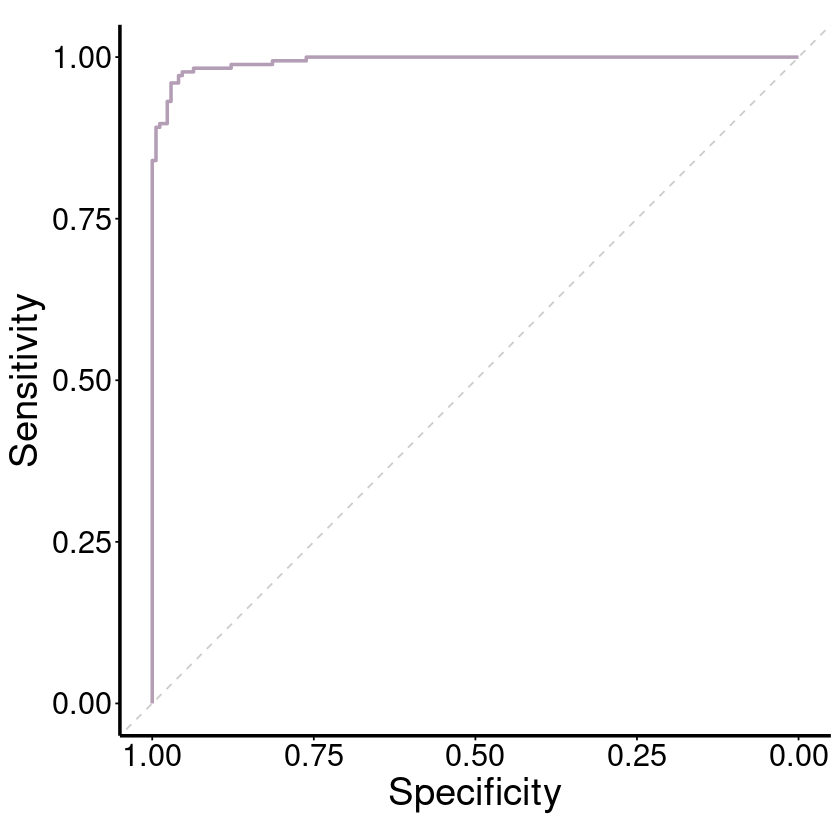

In [2]:
suppressMessages(library(cvAUC))
suppressMessages(library(pROC))
suppressMessages(library(ggplot2))

pred_tab <- read.table(file = "Cardiomyocytes_vs_other_pred.txt", header = T, stringsAsFactors = F)
roc_pred_tab <- roc(pred_tab$true_class, pred_tab$prob, direction="<")
rocs.list <- list(roc_pred_tab)
# Plot ROC curves
p <- ggroc(rocs.list, size = 1) + theme(panel.border = element_blank(), panel.grid.major = element_blank()
                                        , panel.grid.minor = element_blank()#legend.position="none" 
                                        , axis.line = element_line(colour = "black", size = 1)
                                        , legend.title = element_blank()
                                        , legend.key=element_blank()
                                        , legend.position = "none"
                                        , legend.key.width = unit(1.5,"cm")
                                        , panel.background = element_blank()
                                        , text = element_text(size=23)
                                        , axis.text.x=element_text(colour="black")
                                        , axis.text.y=element_text(colour="black")
                                        , legend.text=element_text(size=24)
                                        , axis.ticks = element_line(colour = "black")) +
  guides(linetype = guide_legend(override.aes = list(size = 3))) +
  geom_abline(slope=1, intercept = 1, linetype = "dashed", alpha=0.8, color = "grey") + coord_equal() +
  scale_colour_manual(values=c("#B39EB5"), aesthetics = c("colour", "fill")) +
  labs(y= "Sensitivity", x = "Specificity")

p

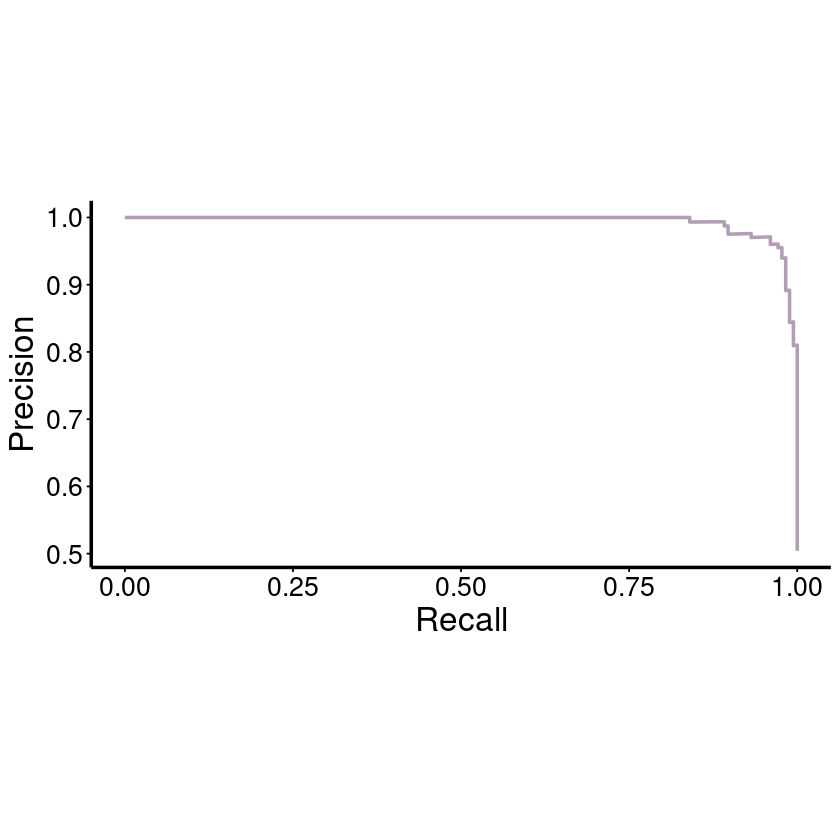

In [3]:
suppressMessages(library("yardstick"))
suppressMessages(library("cvAUC"))
suppressMessages(library(pROC))
suppressMessages(library(ggplot2))

pred_tab <- read.table(file = "Cardiomyocytes_vs_other_pred.txt", header = T, stringsAsFactors = F)

pred_tab$true_class <- factor(pred_tab$true_class, levels=c(0,1))  
curve <- pr_curve(pred_tab, truth=true_class, prob, event_level="second")

my_theme <-  theme(panel.border = element_blank(), panel.grid.major = element_blank()
                   , panel.grid.minor = element_blank()#legend.position="none"
                   , axis.line = element_line(colour = "black", size = 1)
                   , legend.title = element_blank()
                   , legend.key=element_blank()
                   , legend.position = c(0.75, 0.25)
                   , legend.key.width = unit(1,"cm")
                   , panel.background = element_blank()
                   , legend.text=element_text(size=15)
                   , text = element_text(size=20)
                   , axis.text.x=element_text(colour="black")
                   , axis.text.y=element_text(colour="black")
                   , axis.ticks = element_line(colour = "black"))

p <- ggplot(curve, aes(x = recall, y = precision)) +
  geom_path(color="#B39EB5", size = 1) +   my_theme +
  labs(y= "Precision", x = "Recall") + coord_equal()
#  scale_colour_manual(values=) + #, aesthetics = c("colour", "fill"))

p


## Interpretation

We will calculate SHAP values to evaluate the contribution of each motif to the classification carried out by our model. SHAP stands for SHapley Additive exPlanations, SHAP values are a concept from game theory to measure the contribution of each player to a game [5]. We are going to create a python virtual environment to calculate SHAP values. SHAP values are calculated for each motif and for each CRE. SHAP values can be positive or negative indicating whether they influence the prediction of the model towards the target class (positive values) or the background class (negative values).

Activate python environment

We can execute the script BOM_SHAP.py to calculate and save the SHAP values of our model 

In [4]:
python BOM_SHAP.py --help

usage: BOM_SHAP.py [-h] [--xgb_model XGB_MODEL] [--train_data TRAIN_DATA]
                   [--out_file OUT_FILE]

Script to calculate and save SHAP values for a binary model

optional arguments:
  -h, --help            show this help message and exit
  --xgb_model XGB_MODEL
                        Path to XGBoost model file
  --train_data TRAIN_DATA
                        Path to training data file
  --out_file OUT_FILE   Path to output file (.txt)


In [9]:
python BOM_SHAP.py --xgb_model Cardiomyocytes_vs_other.bin --train_data Cardiomyocytes_vs_other_train.txt --out_file Cardiomyocytes_vs_other_SHAP.txt

Reading model...
Reading data...
Calculating SHAP values...
Saving SHAP values...
Done


We can see we have a SHAP value for each motif and each CRE. Columns represent different motifs, the name of the column represents the motif ID in the motif database. CRE are represented by their coordinates in the row names.

In [4]:
shap <- read.table(file = "Cardiomyocytes_vs_other_SHAP.txt", header = T, stringsAsFactors = F, sep ='\t')
head(shap[,1:10])

X                     GM.5.0.AP.2.0001 GM.5.0.AP.2.0002 GM.5.0.AP.2.0003
1 1:39855911-39856411    0.0002013122     0.0009980025    5.660088e-05    
2 2:157923362-157923862 -0.0049727662    -0.0139227007    9.613279e-04    
3 13:96570604-96571104   0.0002995325    -0.0013343395    6.773737e-05    
4 3:107514257-107514757  0.0023425999     0.0005391871    9.613279e-04    
5 14:22510336-22510836   0.0002368100     0.0003979383    5.660088e-05    
6 11:68623429-68623929   0.0003433939    -0.0021888763    6.773737e-05    
  GM.5.0.AP.2.0004 GM.5.0.AP.2.0005 GM.5.0.AP.2.0006 GM.5.0.AP.2.0007
1  0.0014850191     0.002796699     0                0               
2 -0.0010331029     0.005620948     0                0               
3  0.0003201419    -0.010013306     0                0               
4  0.0016896832     0.002278419     0                0               
5  0.0003060517     0.002345784     0                0               
6  0.0002883063    -0.009020381     0                0               
  GM.5.0.AP.2.0008 GM.5.0.AP.2.0009
1  0.0004878961    0               
2 -0.0077172318    0               
3  0.0003714848    0               
4  0.0004901579    0               
5  0.0003548257    0               
6  0.0007966476    0

## SHAP beeswarm plot 
SHAP beeswarm plots display the SHAP values for each data point (CRE) for a specified number of features (motifs). Motifs are ranked based on the sum of the absolute SHAP values, a measure of the overall motif importance. The colour of the dots is given by the normalised value of the features (motif counts) to a range from zero to one. Using the script BOM_SHAP_beeswarm.py we can define whether to display the ID of the motif, as in the database, or a transcription factor name (default). GIMME motifs are clusters of very similar motifs recognized by different transcription factors (TF). The motif names displayed represent the first TF name included in the annotation of GIMME motifs.

In [3]:
python BOM_SHAP_beeswarm.py --help 

usage: BOM_SHAP_beeswarm.py [-h] [--xgb_model XGB_MODEL]
                            [--train_data TRAIN_DATA] [--out_file OUT_FILE]
                            [--motif_names MOTIF_NAMES] [--out_SHAP OUT_SHAP]
                            [--max_display MAX_DISPLAY] [--features FEATURES]
                            [--feature_names FEATURE_NAMES [FEATURE_NAMES ...]]
                            [--plot_type {dot,bar,violin,compact_dot}]
                            [--color COLOR] [--axis_color AXIS_COLOR]
                            [--title TITLE] [--alpha ALPHA] [--show SHOW]
                            [--sort SORT] [--color_bar COLOR_BAR]
                            [--plot_size PLOT_SIZE]
                            [--layered_violin_max_num_bins LAYERED_VIOLIN_MAX_NUM_BINS]
                            [--class_names CLASS_NAMES [CLASS_NAMES ...]]
                            [--class_inds CLASS_INDS [CLASS_INDS ...]]
                            [--color_bar_label COLOR_BAR_LABEL] [

By default the script BOM_SHAP_beeswarm.py will display motif names.

In [6]:
python BOM_SHAP_beeswarm.py --xgb_model=Cardiomyocytes_vs_other.bin --train_data=Cardiomyocytes_vs_other_train.txt --out_file=Cardiomyocytes_vs_other_SHAP_beeswarmv1.png 

Reading model...
Reading data...
Calculating SHAP values...
Reading GIMME motifs annotation...
Saving beeswarm plot...
Figure(800x950)
Done


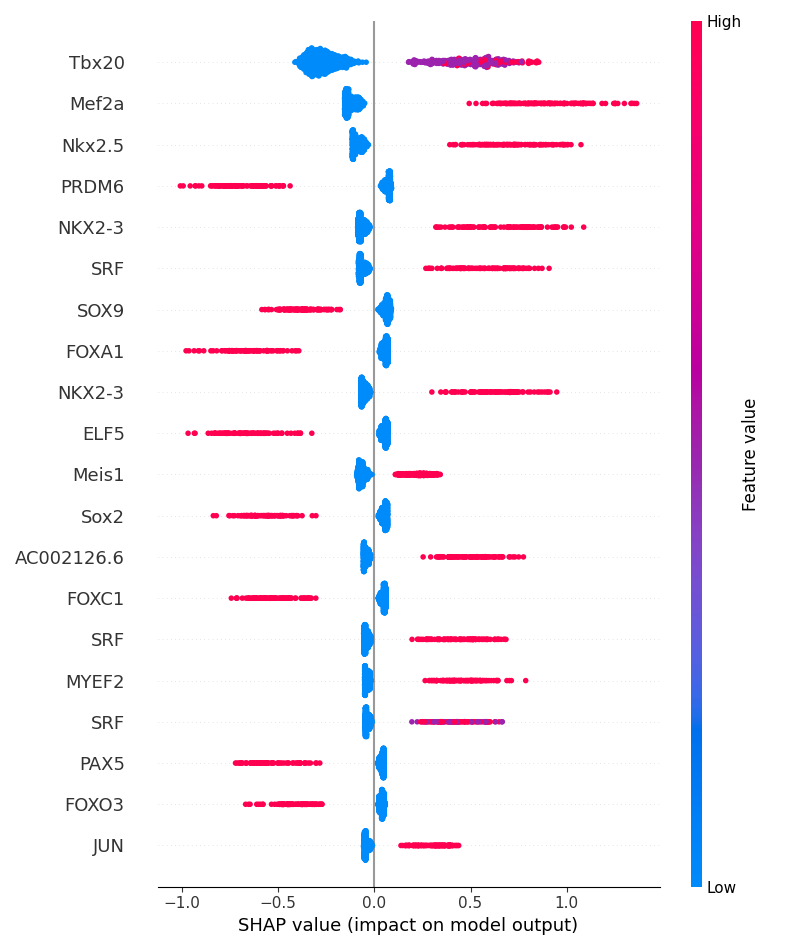

In [2]:
from IPython.display import Image

# get the image
Image("Cardiomyocytes_vs_other_SHAP_beeswarmv1.png", width=500, height=500)

We can set --motif_names to False to display motif IDs

In [13]:
python BOM_SHAP_beeswarm.py --xgb_model=Cardiomyocytes_vs_other.bin --train_data=Cardiomyocytes_vs_other_train.txt --out_file=Cardiomyocytes_vs_other_SHAP_beeswarmv2.png --motif_names=False


Reading model...
Reading data...
Calculating SHAP values...
Saving beeswarm plot...
Figure(800x950)
Done


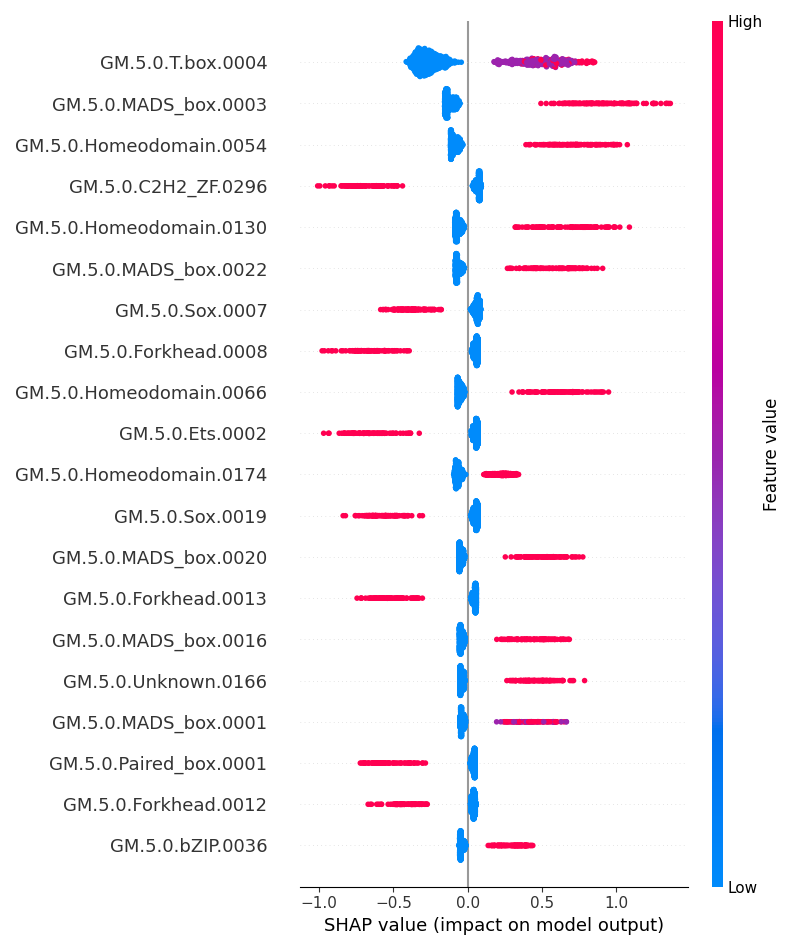

In [3]:
from IPython.display import Image

# get the image
Image("Cardiomyocytes_vs_other_SHAP_beeswarmv2.png", width=500, height=500)

## SHAP bar plot of motif importance

SHAP barplots display an overall value of feature (motif) importance, defined as the mean of absolute SHAP values for each motif. By default the top 10 features are shown. In this script we can also define whether to use motif names or motif IDs.

In [17]:
python BOM_SHAP_barplot.py --help

usage: BOM_SHAP_barplot.py [-h] [--xgb_model XGB_MODEL]
                           [--train_data TRAIN_DATA] [--out_file OUT_FILE]
                           [--motif_names MOTIF_NAMES] [--out_SHAP OUT_SHAP]
                           [--max_display MAX_DISPLAY]
                           [--order ORDER [ORDER ...]]
                           [--hclustering HCLUSTERING]
                           [--clustering_cutoff CLUSTERING_CUTOFF]
                           [--merge_cohorts MERGE_COHORTS]
                           [--show_data SHOW_DATA] [--show SHOW]

Script to produce a SHAP barplot of overall motif importance in a BOM binary
model.

optional arguments:
  -h, --help            show this help message and exit
  --xgb_model XGB_MODEL
                        Path to XGBoost model file
  --train_data TRAIN_DATA
                        Path to training data file
  --out_file OUT_FILE   Path to output PDF or png file
  --motif_names MOTIF_NAMES
                        Whether to use 

In [18]:
python BOM_SHAP_barplot.py --xgb_model=Cardiomyocytes_vs_other.bin --train_data=Cardiomyocytes_vs_other_train.txt --out_file=Cardiomyocytes_vs_other_bar1.png --max_display=15 --motif_names=True

Reading model...
Reading motif counts...
Calculating SHAP values of motif contribution...
Reading GIMME motifs annotation...
Saving plot...
Figure(800x900)
Done


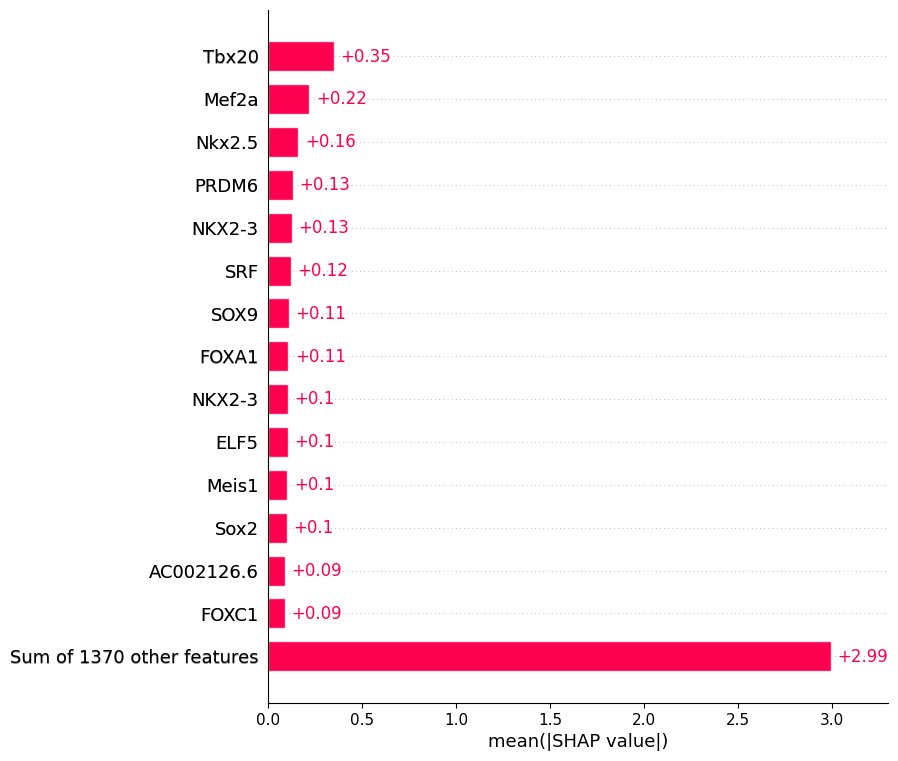

In [4]:
from IPython.display import Image

# get the image
Image("Cardiomyocytes_vs_other_bar1.png", width=500, height=500)

## Waterfall plot of local motif importance 

Given that SHAP values are calculated for each CRE, we can evaluate the local explanation of individual CRE. For this, we will plot a waterfall plot. This kind of plot will show in different colors the sign (direction) of SHAP values for indivisual CREs. The SHAP and feature value are shown for each motif. The feature value meaning the count of motifs of every type in the CRE sequence. We have selected three cardiomyocyte-specific CRE as examples. As in previous plots, motifs are ranked based on their absolute SHAP values.

In [20]:
python BOM_SHAP_waterfall.py --help

usage: BOM_SHAP_waterfall.py [-h] [--xgb_model XGB_MODEL]
                             [--train_data TRAIN_DATA] [--regions REGIONS]
                             [--motif_names MOTIF_NAMES]
                             [--max_display MAX_DISPLAY] [--show SHOW]
                             [--out_format OUT_FORMAT]

Script to perform operations on a model.

optional arguments:
  -h, --help            show this help message and exit
  --xgb_model XGB_MODEL
                        Path to XGBoost model file
  --train_data TRAIN_DATA
                        Path to training data file
  --regions REGIONS     Path to regions IDs for local explanation
  --motif_names MOTIF_NAMES
                        Whether to use the motif names instead of motif IDs
                        (default: True)
  --max_display MAX_DISPLAY
                        Number of motifs to display (default: 10)
  --show SHOW           Whether to display the plot
  --out_format OUT_FORMAT
                        Format 

In [5]:
python BOM_SHAP_waterfall.py --xgb_model=Cardiomyocytes_vs_other.bin --train_data=Cardiomyocytes_vs_other_train.txt --regions=CRE_sample_card

Reading model...
Reading data...
Calculating SHAP values...
Reading GIMME motifs annotation...
Saving beeswarm plot...
Saving 1_39855911_39856411_waterfall.png ...
Figure(800x650)
Saving 2_157923362_157923862_waterfall.png ...
Figure(800x650)
Saving 9_23116275_23116775_waterfall.png ...
Figure(800x650)
Done


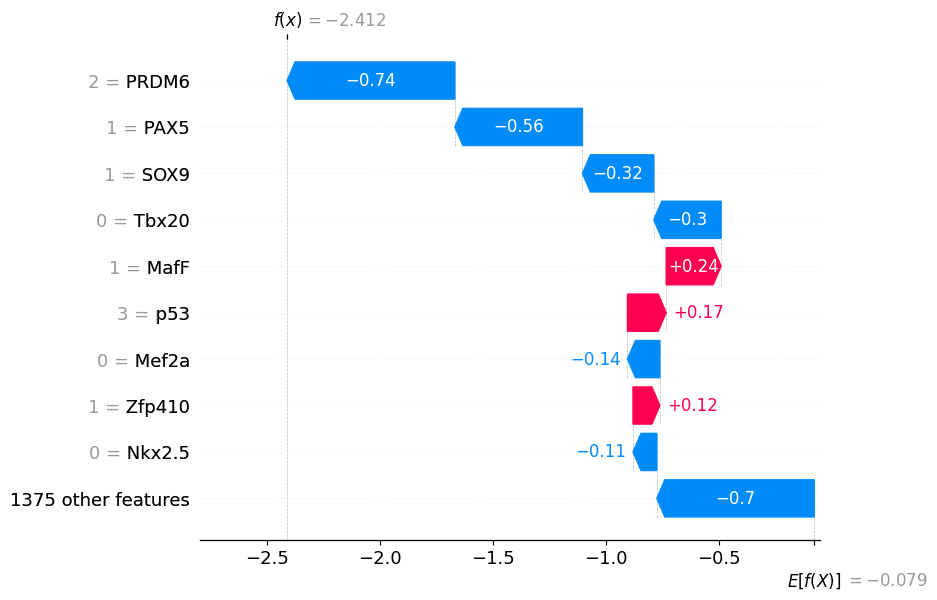

In [7]:
from IPython.display import Image
# get the image
Image("1_39855911_39856411_waterfall.png", width=500, height=500)

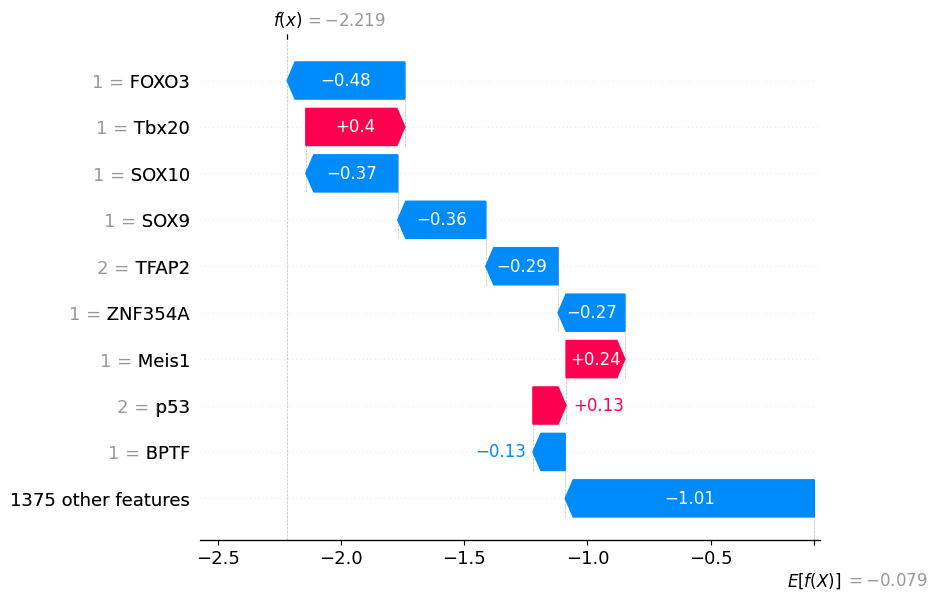

In [8]:
Image("2_157923362_157923862_waterfall.png", width=500, height=500)

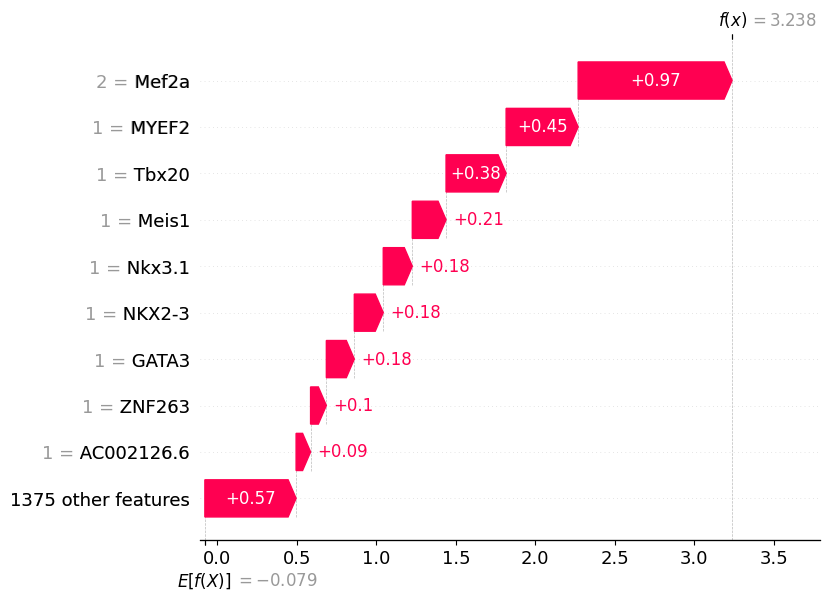

In [9]:
Image("9_23116275_23116775_waterfall.png", width=500, height=500)

## Rank motifs by their overall importance in CRE binary classification

The motif ranking implemented in SHAP plots could be useful for multiple downstream analysis. Using the script rank_motifs.R we can get this ranking based on either the sum of absolute SHAP or mean of the absolute SHAP per motif. Both ranking metrics are highly consistent.

In [2]:
Rscript rank_motifs.R --help

Usage: Rscript rank_motifs.R [parameters]

Parameters:
  --shap_file=<file>       Path to the SHAP values file
  --out_file=<file>      Path to save the motifs ranked by SHAP
  --rank_type=<file>      Rank type. Either 'sum' or 'mean' 



In [5]:
Rscript rank_motifs.R --shap_file=Cardiomyocytes_vs_other_SHAP.txt --out_file=Cardiomyocytes_vs_other_Motif_rank1 --rank_type=mean

Reading SHAP values...
Ranking motifs by SHAP...
Saving ranked motifs...
Done


In [6]:
Rscript rank_motifs.R --shap_file=Cardiomyocytes_vs_other_SHAP.txt --out_file=Cardiomyocytes_vs_other_Motif_rank2 --rank_type=sum

Reading SHAP values...
Ranking motifs by SHAP...
Saving ranked motifs...
Done


In [10]:
head Cardiomyocytes_vs_other_Motif_rank1

mean_abs_SHAP
GM.5.0.T.box.0004 0.348914314613564
GM.5.0.MADS_box.0003 0.217864508280769
GM.5.0.Homeodomain.0054 0.159735312075843
GM.5.0.C2H2_ZF.0296 0.130275805270133
GM.5.0.Homeodomain.0130 0.12624345631612
GM.5.0.MADS_box.0022 0.120348175534041
GM.5.0.Sox.0007 0.10757551501981
GM.5.0.Forkhead.0008 0.106609145923373
GM.5.0.Homeodomain.0066 0.104904772688682


In [11]:
head Cardiomyocytes_vs_other_Motif_rank2

sum_abs_SHAP
GM.5.0.T.box.0004 362.521972883493
GM.5.0.MADS_box.0003 226.361224103719
GM.5.0.Homeodomain.0054 165.964989246801
GM.5.0.C2H2_ZF.0296 135.356561675668
GM.5.0.Homeodomain.0130 131.166951112449
GM.5.0.MADS_box.0022 125.041754379869
GM.5.0.Sox.0007 111.770960105583
GM.5.0.Forkhead.0008 110.766902614385
GM.5.0.Homeodomain.0066 108.996058823541


### References

1. Pijuan-Sala, B., Wilson, N. K., Xia, J., Hou, X., Hannah, R. L., Kinston, S., ... & Göttgens, B. (2020). Single-cell chromatin accessibility maps reveal regulatory programs driving early mouse organogenesis. Nature cell biology, 22(4), 487-497.
2. Bruse, N., & Heeringen, S. J. V. (2018). GimmeMotifs: an analysis framework for transcription factor motif analysis. BioRxiv, 474403.
3. Charles E. Grant, Timothy L. Bailey and William Stafford Noble, "FIMO: Scanning for occurrences of a given motif", Bioinformatics 27(7):1017-1018, 2011. [full text]
4. Quinlan, A. R., & Hall, I. M. (2010). BEDTools: a flexible suite of utilities for comparing genomic features. Bioinformatics, 26(6), 841-842.
5. Lundberg, S. M., Erion, G., Chen, H., DeGrave, A., Prutkin, J. M., Nair, B., ... & Lee, S. I. (2020). From local explanations to global understanding with explainable AI for trees. Nature machine intelligence, 2(1), 56-67.